In [1]:
from models import generate_model, get_epistemic_uncertainty
from utils import load_data, real_class_dictionary

In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import load_model

batch_size = 32
epochs = 20
num_classes = 3

metrics = ['accuracy']

loss_func = tf.keras.losses.categorical_crossentropy

In [3]:
##RUN NOTEBOOK IN TRAINING MODE OR LOAD MODEL, HISTORY AND COLCULATED UNCERTAINCY FROM BACKUP
    #    trained = False --> training mode 

trained = False
# trained = True


real_labels = ["AC", "AD", "H"]
noise_labels = ["blood", "fat", "glass", "stroma"]

#back up files
base_path = "results/"
model_back_up = base_path + "model.h5"
history_back_up = base_path + "history.csv"
uncertainty_back_up = base_path + "uncertainty.csv"

# Introduction

In real world application cases it is very difficult to have clean data set without noises., for this reason it is essential to have an approach to be able to estimate the uncertainty of the classification. one of the solution may be considered Bayesian Convolutional Neural Networks that allow to find posterior distribution from which can be found uncertainty of the model parameters. However it is computationally intractable since require to perform integration over entire the space of parameters of the model.[Kwon et al., 2018] The solution of this problem is the drop out method that allow to approximate the Bayesian inference. [Gal, 2015]

## set up and load data

In order to load train and test data sets I have implement the function "load_data", that in place convert all labels in one hot encoding. In the case of train data set all data is splitted into train and validation subsets by sklearn function "train_test_split" in proportion 80/20. Also for convenience of noise analysis i convert data set of real class labels into a dictionary with string of real class as keys and as values the array of indexes of the corresponding data set vector.

In [4]:

#data set is expected to be in data folder
x_data, y_data, real_train_class = load_data("train", base_path = "data/")

train_data_size = x_data[0].shape
valid_data_size = x_data[1].shape

# sampes number, width, height, chanel
print(f"train data shape {train_data_size}")
print(f"validation data shape {valid_data_size}")

# width, height, chanel
input_data_size = train_data_size[1:]
print(f"input data shape {input_data_size}")

index_real_class = real_class_dictionary(real_train_class)
print(f"real class lables {index_real_class.keys()}")

train data shape (9868, 32, 32, 3)
validation data shape (2468, 32, 32, 3)
input data shape (32, 32, 3)
real class lables dict_keys(['AC', 'AD', 'H', 'blood', 'fat', 'glass', 'stroma'])


In [5]:
x_test_data, y_test_data, real_test_class = load_data("test", base_path = "data/")

test_dim = x_test_data.shape
print(f"data shape {x_test_data.shape}")

index_test_real_class = real_class_dictionary(real_test_class)


data shape (7308, 32, 32, 3)


# model

Model is generated by a function "generate_model", that take as arguments the number of classes, input size, number of layers and dropout rate. Such method allows me to have better control over some initial set up of the model and architecture. So after several attempt I was able to find optimal configuration for the model.

In order to implement Bayesian Convolutional Neural Network for multi class classification I choose the sequential architecture composed of 3 convolutional layers each of that is followed by max pooling layer and dropout layer. As final stage I added the flatten layer that prepare the input for dense layer followed again by drop out layer. At each new convolutional layer I double the number of filters - starting from 32 - and set the kernel dimension to (3,3), except the first one where I used kernel dimension (5,5). For each layer I used "same" padding and the relu-activation function, as consequence I used he_normal-initializer for weight initialization. Instead for the last output dense layer I used softmax-activation function as have been suggested by [Kwon et al., 2018]. also I forced drop out layer to be active in training and test phase. The main role of the dropout is to randomly turn off some of the inputs to the layer. In this way in training phase it prevent oferfitting, indeed in this way neurons doesn't learn exactly the training data set. From other hand in test phase drop out allow some degree of uncertainty in evaluation and prediction of new samples that allow to approximate posterior distribution[Gal, 2015] and thus estimate variations.

I compile the model with categorical cross entropy as a loss function, Adam optimizer and accuracy as metrics. After that I trained the model for 25 epoch, that seems optimal in training and evaluation performance, since training and evaluation loss/accuracy started to deviate. 

Finally I saved the model and history.

In [8]:
if trained:
    print("model already havse been trained")
    model = load_model(model_back_up)
    model.summary()
    df = pd.read_csv(history_back_up)
    
    #SHOULDN'T BE DONE
    from tensorflow.keras.callbacks import History
    mod_history = History()
    mod_history.history = {"accuracy": df["accuracy"],
                  "val_accuracy": df["val_accuracy"],
                  "loss": df["loss"],
                  "val_loss": df["val_loss"]}
else:
    model = generate_model(num_classes, input_data_size, layer_num = 3, drop_rate = 0.25)
    model.summary()
    model.compile(loss = loss_func, 
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = metrics)
    mod_history = model.fit(x_data[0], y_data[0], 
                                    batch_size = batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(x_data[1], y_data[1]))
    
    
    model.save(model_back_up)
    history_data_set = pd.DataFrame({"accuracy": mod_history.history["accuracy"],
                      "val_accuracy": mod_history.history["val_accuracy"],
                       "loss": mod_history.history["loss"],
                       "val_loss": mod_history.history["val_loss"],}) 
    with open(history_back_up, mode='w') as f:
        history_data_set.to_csv(f)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                       

## performance

As may be seen from plot below accuracy and the loss of the train and validation data set present the same behavior, except some fluctuation in validation accuracy and loss. Also both characteristics achieve almost stable and satisfactory values of accuracy and loss. In this way at first analysis the model learn well from training data set and avoid overfitting. 

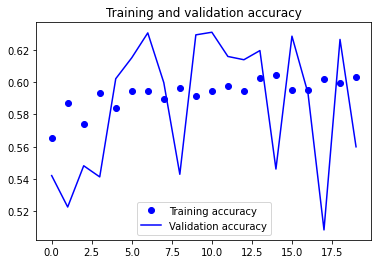

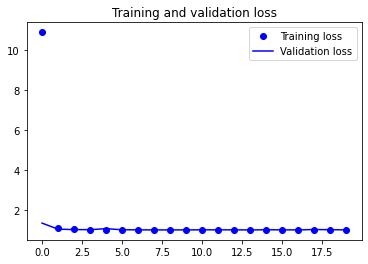

In [9]:
accuracy = mod_history.history['accuracy']
val_accuracy = mod_history.history['val_accuracy']


loss = mod_history.history['loss']
val_loss = mod_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(base_path + 'accuracy_vs_epoch.png')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')


plt.legend()
plt.savefig(base_path + 'loss_vs_epoch.png')
plt.show()


## evaluate model on test data set

At the next step I evaluated model on the trained data set. As results obtained values of loss is quite hight and accuracy is rather low. This can be explained by the fact that in train and test data present noise that give low contribution to overall accuracy and hight contribution to the loss.

In [10]:
test_eval = model.evaluate(x_test_data, y_test_data[1], verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])


229/229 [==============================] - 5s 22ms/step - loss: 1.1711 - accuracy: 0.5472
Test loss: 1.1711490154266357
Test accuracy: 0.5472085475921631


# uncertainty analisis

Since the noise data is labeled in the same way as the samples of interests, it is required an approach to to deal with such miss classifications. One way may be to evaluate the uncertainty of all test sample and set a threshold that would cut off most of the noise samples.

## epistemic uncertainty

Using the method proposed in [Kwon et al., 2018] it is possible to estimate aleatoric and epistemic uncertainty. Aleatoric uncertainty capturing noise inherent in the observations and epistemic uncertainty accounts for model uncertainty, so it may be used to evaluate the uncertainty on the prediction done by the model. Indeed due to implementing drop out in the evaluation phase prediction probability $\hat{p}_t = p(\omega_t) = SoftMax(f^{\hat{\omega}_t}(x*))$ will be different in each evaluation experiment and effect of drop out may be seen as randomization of parameters of the model $\omega$ according to the variational predictive distribution $q_{\hat{\theta}}(\omega)$[Kwon et al., 2018]


In ordder to calculate the epistemic uncertainty I used formula 4) from [Kwon et al., 2018]:


\begin{align*}
Var(y) &= \frac{1}{T} \sum_{t=1}^T (\hat{p}_t - \bar{p})(\hat{p}_t - \bar{p})^T\\
\bar{p} &= \frac{1}{T} \sum_{t=1}^T \hat{p}\\
\hat{p}_t &= p(\omega_t) = SoftMax(f^{\hat{\omega}_t}(x*))
\end{align*}


,where $f^{\hat{\omega}_t}(x*)$ is the output of the last dense layer.

the implementation of calculus of epistemic uncertainty have been done in the function "get_epistemic_uncertainty", that have been adapted from the code proposed by [Kwon et al., 2018]. Using the mean prediction probability the samples are classified considering label with probability larger than 0.5 - unambiguous classification - the other samples are rejected.

In order to find the distribution of the uncertainty over all samples I run the loop over entire test set and calculated it for each sample. After that I sorted unambiguously classified samples according to the real labels into corresponding arrays. In this way the noise analysis can be done more effectively and can be avoid the problem of false positive. from the other hand to estimate miss classification of the labels of interest (e.i. "AC", "AD", "H") I store classified labels into dictionary with corresponding real class as keys.

In [11]:
trained = False
if trained:
    df = pd.read_csv(uncertainty_back_up)
    epistemic_lable_uncertainty_AC = np.array([i for i in df["AC_uncertainty"]  if not pd.isna(i) ])
    epistemic_lable_uncertainty_AD = np.array([i for i in df["AD_uncertainty"]  if not pd.isna(i) ])
    epistemic_lable_uncertainty_H = np.array([i for i in df["H_uncertainty"]  if not pd.isna(i) ])

    epistemic_lable_uncertainty_blood = np.array([i for i in df["blood_uncertainty"]  if not pd.isna(i) ])
    epistemic_lable_uncertainty_fat = np.array([i for i in df["fat_uncertainty"]  if not pd.isna(i) ])
    epistemic_lable_uncertainty_glass = np.array([i for i in df["glass_uncertainty"]  if not pd.isna(i) ])
    epistemic_lable_uncertainty_stroma = np.array([i for i in df["stroma_uncertainty"]  if not pd.isna(i) ])
    
else:
    dic_predictions = {"AC": [], "AD": [], "H": []}
    epistemic_lable_uncertainty_AC = []
    epistemic_lable_uncertainty_AD = []
    epistemic_lable_uncertainty_H = []
    epistemic_lable_uncertainty_blood = []
    epistemic_lable_uncertainty_fat = []
    epistemic_lable_uncertainty_glass = []
    epistemic_lable_uncertainty_stroma = []
    
    prediction, epistemic = get_epistemic_uncertainty(model, x_test_data, T = 15)
    
    for i in range(test_dim[0]):
        #take into account olny samples that can be predicted --> prediction probability > 0.5
            #uncertaincy of false positive is excluded, 
            #because result have been ordered according real class-lable. 
            #So results in each arrya effectively belong to the corresponding real class
                
            #?may be present false negative
                #samples of some class with higth uncertaincy may be predicted to belong to wrong class


        if len(prediction[i][0]) != 0:
            if real_test_class[i] == "AC":
                dic_predictions["AC"] = np.append(dic_predictions["AC"], np.squeeze(prediction[i]))
                epistemic_lable_uncertainty_AC.append(epistemic[i])

            elif real_test_class[i] == "AD":
                dic_predictions["AD"] = np.append(dic_predictions["AD"], np.squeeze(prediction[i]))
                epistemic_lable_uncertainty_AD.append(epistemic[i])

            elif real_test_class[i] == "H":
                dic_predictions["H"] = np.append(dic_predictions["H"], np.squeeze(prediction[i]))
                epistemic_lable_uncertainty_H.append(epistemic[i])

            elif real_test_class[i] == "blood":
                epistemic_lable_uncertainty_blood.append(epistemic[i])

            elif real_test_class[i] == "fat":
                epistemic_lable_uncertainty_fat.append(epistemic[i])

            elif real_test_class[i] == "glass":
                epistemic_lable_uncertainty_glass.append(epistemic[i])

            elif real_test_class[i] == "stroma":
                epistemic_lable_uncertainty_stroma.append(epistemic[i])


In [12]:
x = [np.array(epistemic_lable_uncertainty_AC), np.array(epistemic_lable_uncertainty_AD), 
    np.array(epistemic_lable_uncertainty_H)]
names = ['AC', 'AD', 'H']
     
    
x2 = [np.array(epistemic_lable_uncertainty_blood),
    np.array(epistemic_lable_uncertainty_fat), np.array(epistemic_lable_uncertainty_glass),
    np.array(epistemic_lable_uncertainty_stroma)]
names2 = ['blood', 'fat', 'glass', 'stroma']

## prediction rate

From the table below can be seen the number of unambiguously classified sample for each label. Neural Network is able pretty well to recognize classes of interest. 

From the other hand noise classes are recognized very bad and most of them are rejected: for example NN wasn't able to discriminate none of samples of glass-class. The rest of noise classes still present very low classification rate. This is desired result since we are are interested into reducing the noise into labeling of the samples of interest.


In [13]:
for (i, m) in zip(x, real_labels):
    print(f"predicted {m} {len(i)} of {len(index_test_real_class[m])}")

print("___"*10+"\n")

for (i, m) in zip(x2, noise_labels):
    print(f"predicted {m} {len(i)} of {len(index_test_real_class[m])}")

print("___"*10+"\n")    

tot = 0
for i in x+x2:
    tot += len(i)
print(f"total classified samples {tot}, of {test_dim[0]}")


predicted AC 64 of 1500
predicted AD 1478 of 1500
predicted H 284 of 1500
______________________________

predicted blood 449 of 570
predicted fat 0 of 522
predicted glass 0 of 639
predicted stroma 85 of 1077
______________________________

total classified samples 2360, of 7308


## threshold estimation  

At the next step I plotted the density of recognized samples vs corresponding uncertainty. The number of samples have been normalized to the number of recognized samples, in this way the density of different classes can be compared more effectively. from the plot below can be seen the the density of valid samples is highly picked around zero uncertainty.

Instead for the noise samples distribution may be seen that most of the samples have large enough uncertainty and most of them may be cut be threshold. However some of the noise classes present a small pick at zero uncertainty, even if very small w.r.t the valid samples density. Due to this fact some fraction of noise persist among right recognized class of interest. However considering that it's only a fraction of already reduced data set overall number of miss classification labels should be rather low.

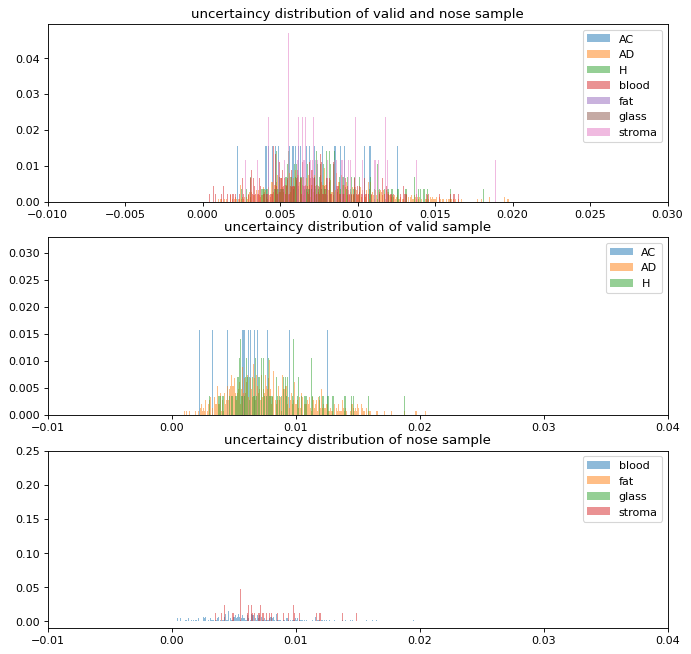

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), dpi=80)


kwargs = dict(alpha = 0.5, stacked = True)

for i in range(3):
    weights = np.ones_like(x[i])/float(len(x[i]))
# print(weights)
#     plt.hist(i[i], label=names[i], weights=weights, **kwargs)
    axs[0].hist(x[i], label=names[i], weights=weights, bins=500, **kwargs)
    axs[1].hist(x[i], label=names[i], weights=weights, bins=500, **kwargs)
    


for j in range(4):
    weights2 = np.ones_like(x2[j])/float(len(x2[j]))
# print(weights2)
#     plt.hist(x2[j], label=names2[j], weights=weights2, **kwargs)
    axs[0].hist(x2[j], label=names2[j], weights=weights2, bins=500,  **kwargs)
    axs[2].hist(x2[j], label=names2[j], weights=weights2, bins=500,  **kwargs)
    


axs[0].set_xlim(-0.01, 0.03)
axs[0].set_title("uncertaincy distribution of valid and nose sample")
axs[0].legend()


axs[1].set_xlim(-0.01, 0.04)
axs[1].set_title("uncertaincy distribution of valid sample")
axs[1].legend()

axs[2].set_xlim(-0.01, 0.04)
axs[2].set_ylim(-0.01, 0.25)
axs[2].set_title("uncertaincy distribution of nose sample")
axs[2].legend()

plt.savefig(base_path + 'uncertainty.png')
plt.show() 

From the table below can be seen the fraction of samples under a uncertainty threshold. 

In [15]:
threshhold = 0.005


good_fraction = []
noise_fraction = []
lable_to_class ={"AC": 0, "AD": 1, "H": 2}

for (i, m) in zip(x, real_labels):
    count = 0
    for j in dic_predictions[m]:
        if j == lable_to_class[m]:
            count += 1
    good_fraction = np.round( len(np.where(i <= threshhold)[0])/len(i), decimals = 4 )
    total_fraction = np.round(len(np.where(i <= threshhold)[0])/len(index_test_real_class[m]), decimals = 4 )
    print(f"fraction of predicted valid samples under treshhold {good_fraction} for {m}")
    print(f"fraction of total valid samples under treshhold {total_fraction} for {m}")
    print(f"number of misss classsificated samples {len(i) - count} of total {len(i)}")
    
    print("\n")

print("___"*10+"\n")    
    

for (i, m) in zip(x2, noise_labels):
    if len(i) != 0:
        noise_fraction = np.round( len(np.where(i <= threshhold)[0])/len(i), decimals = 4 )
        total_fraction = np.round(len(np.where(i <= threshhold)[0])/len(index_test_real_class[m]), decimals = 4 )
        print(f"fraction of predicted noise samples under treshhold {noise_fraction} for {m}")
        print(f"fraction of total noise samples under treshhold {noise_fraction} for {m}")
    else:
        print(f"{m} haven't been predicted")
        
    print("\n")


fraction of predicted valid samples under treshhold 0.2188 for AC
fraction of total valid samples under treshhold 0.0093 for AC
number of misss classsificated samples 64 of total 64


fraction of predicted valid samples under treshhold 0.1867 for AD
fraction of total valid samples under treshhold 0.184 for AD
number of misss classsificated samples 0 of total 1478


fraction of predicted valid samples under treshhold 0.1197 for H
fraction of total valid samples under treshhold 0.0227 for H
number of misss classsificated samples 284 of total 284


______________________________

fraction of predicted noise samples under treshhold 0.3029 for blood
fraction of total noise samples under treshhold 0.3029 for blood


fat haven't been predicted


glass haven't been predicted


fraction of predicted noise samples under treshhold 0.1176 for stroma
fraction of total noise samples under treshhold 0.1176 for stroma




# reference

[Kwon et al., 2018] Kwon, Yongchan, et al. "Uncertainty quantification using bayesian neural networks in classification: Application to ischemic stroke lesion segmentation." (2018).

[Gal, 2015] Gal, Yarin, and Zoubin Ghahramani. "Dropout as a bayesian approximation: Representing model uncertainty in deep learning."(2015)

In [15]:

# uncertainty_back_up = "unc.csv"

uncertaincy_data_set = pd.DataFrame.from_dict({"AC_uncertainty": epistemic_lable_uncertainty_AC,
                                    "AD_uncertainty": epistemic_lable_uncertainty_AD,
                                    "H_uncertainty": epistemic_lable_uncertainty_H,
                                    "blood_uncertainty": epistemic_lable_uncertainty_blood,
                                    "fat_uncertainty": epistemic_lable_uncertainty_fat,
                                    "glass_uncertainty": epistemic_lable_uncertainty_glass,
                                    "stroma_uncertainty": epistemic_lable_uncertainty_stroma}, orient='index')

with open(uncertainty_back_up, mode='w') as f:
    uncertaincy_data_set.transpose().to_csv(uncertainty_back_up)